In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
def entropy(frequencies: np.array) -> float:
    H = 0
    for p in frequencies:
        H += p*np.log(p)
    H = -np.around(H,decimals=4)
    return H

In [4]:
def gini(frequencies: np.array) -> float:
    H = 0
    for p in frequencies:
        H += p*(1-p)
        
    return H

Здесь мы напишем и протестируем собственную реализацию решающего дерева.

In [5]:
from collections import Counter
from typing import Dict, List, Tuple, Union
import collections

In [6]:
def mean_between_pairs(array: np.array)->np.array:
    array = np.unique(array)
    if len(array) == 1:
        return array + 0.5
    else:
        return np.array((array[:-1] + array[1:])/2)

In [7]:
def split_node(array_of_features: np.array, target, t: float):
    return (array_of_features < t, array_of_features >= t)

In [8]:
def squared_difference(f_value, s_value):
    return (f_value - s_value) ** 2

In [9]:
def optimal_parametres(features: np.array, target: np.array, arrray_of_t: np.array, task: str)->float:
    errors = []
    ginis = []
    def q_error(root_node:np.array, task: str, target:np.array, t: float) -> float:
        left_, right_ = split_node(root_node, target, t)
        left = root_node[left_]
        right = root_node[right_]
        classes_left = target[left_]
        classes_right = target[right_]

        if (task == 'classification'):
            counter_l = collections.Counter(classes_left)
            counter_r = collections.Counter(classes_right)
            prob_l = np.array(list(counter_l.values()))/len(left)
            prob_r = np.array(list(counter_r.values()))/len(right)
                
            H_l = gini(prob_l)
            H_r = gini(prob_r)
            ginis.append(gini(target) - len(left) / len(features) * H_l - len(right) / len(features) * H_r)
        elif (task == 'regression'):
            H_l = np.var(classes_left)
            H_r = np.var(classes_right)
            ginis.append(np.var(target) - len(left) / len(features) * H_l - len(right) / len(features) * H_r)
        
        return len(left) / len(root_node) * H_l + len(right) / len(root_node) * H_r

    for threshold in arrray_of_t:
        errors.append(q_error(root_node=features, target=target, task=task, t=threshold))
    optimal_threshold = arrray_of_t[np.argmin(errors)]
    optimal_gini = ginis[np.argmin(errors)]
    return ginis, optimal_threshold, optimal_gini, errors 

In [10]:
def find_best_split(
    feature_vector: Union[np.ndarray, pd.DataFrame], 
    target_vector: Union[np.ndarray, pd.Series],
    task: str = "classification",
    feature_type: str = "real"
) -> Tuple[np.ndarray, np.ndarray, float, float]:
    if len(np.unique(feature_vector)) == 1:
        possible_thresholds = np.array([feature_vector[0]+0.33])
    else: 
        possible_thresholds = mean_between_pairs(feature_vector)
    overall_ginis, optimal_threshold, optimal_gini, Q = optimal_parametres(features=feature_vector,
                                                                        target=target_vector, 
                                                                        arrray_of_t=possible_thresholds,
                                                                        task=task)
    
    return (possible_thresholds, overall_ginis, optimal_threshold, optimal_gini, Q)

Эту функцию можно протестировать на датасете `Boston` из `sklearn`.

In [12]:
from sklearn.datasets import load_boston

boston = load_boston()
X = pd.DataFrame(data=boston["data"], columns=boston["feature_names"])
y = boston["target"]

C:\Users\nikita\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function load_boston is deprecated; `load_boston` is deprecated in 1.0 and will be removed in 1.2.

    The Boston housing prices dataset has an ethical problem. You can refer to
    the documentation of this function for further details.

    The scikit-learn maintainers therefore strongly discourage the use of this
    dataset unless the purpose of the code is to study and educate about
    ethical issues in data science and machine learning.

    In this special case, you can fetch the dataset from the original
    source::

        import pandas as pd
        import numpy as np


        data_url = "http://lib.stat.cmu.edu/datasets/boston"
        raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
        data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
        target = raw_df.values[1::2, 2]

    Alternative datasets include the California housing dataset 

In [13]:
thresholds, variances, threshold_best, variance_best, Q = find_best_split(
    X["CRIM"].to_numpy(), 
    y, 
    task="regression",
    feature_type="real"
)

In [14]:
X.head(10)

CRIM    ZN  INDUS  CHAS    NOX     RM    AGE     DIS  RAD    TAX  \
0  0.00632  18.0   2.31   0.0  0.538  6.575   65.2  4.0900  1.0  296.0   
1  0.02731   0.0   7.07   0.0  0.469  6.421   78.9  4.9671  2.0  242.0   
2  0.02729   0.0   7.07   0.0  0.469  7.185   61.1  4.9671  2.0  242.0   
3  0.03237   0.0   2.18   0.0  0.458  6.998   45.8  6.0622  3.0  222.0   
4  0.06905   0.0   2.18   0.0  0.458  7.147   54.2  6.0622  3.0  222.0   
5  0.02985   0.0   2.18   0.0  0.458  6.430   58.7  6.0622  3.0  222.0   
6  0.08829  12.5   7.87   0.0  0.524  6.012   66.6  5.5605  5.0  311.0   
7  0.14455  12.5   7.87   0.0  0.524  6.172   96.1  5.9505  5.0  311.0   
8  0.21124  12.5   7.87   0.0  0.524  5.631  100.0  6.0821  5.0  311.0   
9  0.17004  12.5   7.87   0.0  0.524  6.004   85.9  6.5921  5.0  311.0   

   PTRATIO       B  LSTAT  
0     15.3  396.90   4.98  
1     17.8  396.90   9.14  
2     17.8  392.83   4.03  
3     18.7  394.63   2.94  
4     18.7  396.90   5.33  
5     18.7  394.12   5.21  
6     15.2  395.60  12.43  
7     15.2  396.90  19.15  
8     15.2  386.63  29.93  
9     15.2  386.71  17.10

In [15]:
thresholds, variances, threshold_best, variance_best, Q = find_best_split(
    X["NOX"].to_numpy(), 
    y, 
    task="regression",
    feature_type="real"
)

Выведим график зависимости значения критерия ошибки от порогового значения при разбиении вершины по признаку `CRIM`.

In [16]:
def dependency_of_Q_to_threshold(array_of_thresholds: np.array, Q:np.array, feature: str):
    fig, ax = plt.subplots(figsize=(10, 8), tight_layout=True)
    plt.scatter(array_of_thresholds[np.argmin(Q)],min(Q), c='r', s=100)
    ax.plot(array_of_thresholds, Q, c='b', ls='--')
    ax.set_xlabel("threshold", fontsize=16)
    ax.set_ylabel("Q", fontsize=16)
    ax.set_title('Q & threholds dependency ' + feature, fontsize=16)
    plt.annotate('minimum of Q', xy=(array_of_thresholds[np.argmin(Q)], min(Q)), 
                 xytext=(array_of_thresholds[np.argmin(Q)]+0.05, min(Q)+1),
                 arrowprops=dict(facecolor='black', shrink=0.05))
    plt.grid()
    plt.show()

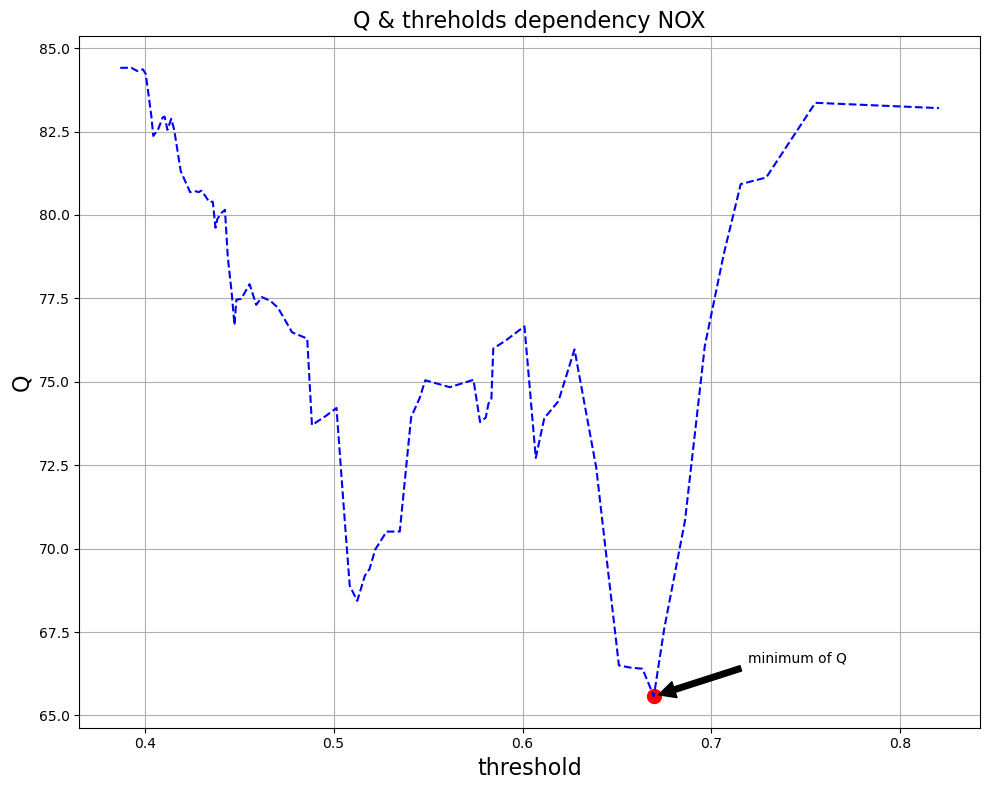

In [17]:
dependency_of_Q_to_threshold(thresholds, Q, "NOX")

In [18]:
from dtreeviz.trees import dtreeviz

In [19]:
class DecisionTree:
    
    def __init__(
        self, 
        feature_types: Union[List[str], np.ndarray], 
        max_depth: int = None, 
        min_samples_split: int = None, 
        min_samples_leaf: int = None,
        task: str = "classification"
    ) -> None:
        
        if np.any(list(map(lambda x: x != "real" and x != "categorical", feature_types))):
            raise ValueError("There is unknown feature type")

        # В этой переменной будем хранить узлы решающего дерева. Каждая вершина хранит в себе идентификатор того,
        # является ли она листовой. Листовые вершины хранят значение класса для предсказания, нелистовые - правого и
        # левого детей (поддеревья для продолжения процедуры предсказания)
        self._tree = {}
        
        # типы признаков (категориальные или числовые)
        self._feature_types = feature_types
        
        # гиперпараметры дерева
        self._max_depth = max_depth
        self._min_samples_split = min_samples_split
        self._min_samples_leaf = min_samples_leaf
        self.task = task

    def _fit_node(
        self, 
        sub_X: np.ndarray, 
        sub_y: np.ndarray, 
        node: dict
    ) -> None:
        
        # критерий останова
        if np.all(sub_y == sub_y[0]):
            node["type"] = "terminal"
            node["class"] = sub_y[0]
            return

        feature_best, threshold_best, gini_best, split = None, None, None, None
        for feature in range(sub_X.shape[1]):
            feature_type = self._feature_types[feature]
            categories_map = {}

            # подготавливаем признак для поиска оптимального порога
            if feature_type == "real":
                feature_vector = sub_X[:, feature]
            elif feature_type == "categorical":
                # здесь могла быть реализация более сложного подхода к обработке категориального признака
                feature_vector = sub_X[:, feature]

            # ищем оптимальный порог
            _, _, threshold, gini, _ = find_best_split(feature_vector, sub_y, self.task, feature_type)
            if gini_best is None or gini > gini_best:
                feature_best = feature
                gini_best = gini

                # split - маска на объекты, которые должны попасть в левое поддерево
                if feature_type == "real":
                    threshold_best = threshold
                    split = feature_vector < threshold_best
                elif feature_type == "categorical":
                    # в данной реализации это просто значение категории
                    threshold_best = threshold
                    split = feature_vector < threshold_best
                else:
                    raise ValueError

        # записываем полученные сплиты в атрибуты класса
        if feature_best is None:
            node["type"] = "terminal"
            node["class"] = Counter(sub_y).most_common(1)[0][0]
            return

        node["type"] = "nonterminal"

        node["feature_split"] = feature_best
        if self._feature_types[feature_best] == "real":
            node["threshold"] = threshold_best
        elif self._feature_types[feature_best] == "categorical":
            node["category_split"] = threshold_best
        else:
            raise ValueError
            
        node["left_child"], node["right_child"] = {}, {}
        self._fit_node(sub_X[split], sub_y[split], node["left_child"])
        self._fit_node(sub_X[np.logical_not(split)], sub_y[np.logical_not(split)], node["right_child"])

    def _predict_node(self, x: np.ndarray, node: dict) -> int:
        """
        Предсказание начинается с корневой вершины дерева и рекурсивно идёт в левое или правое поддерево в зависимости 
        от значения предиката на объекте. Листовая вершина возвращает предсказание.
        :param x: np.array, элемент выборки
        :param node: dict, вершина дерева
        """
        # ᕕ(╭ರ╭ ͟ʖ╮•́)⊃¤=(————-
        
        if node['type'] == 'terminal':
            return node['class']
        
        if self._feature_types[node['feature_split']] == "real":
            if x[node['feature_split']] < node["threshold"]:
                return self._predict_node(x, node['left_child'])
            return self._predict_node(x, node['right_child'])

        if self._feature_types[node['feature_split']] == "categorical":
            if x[node['feature_split']] < node["category_split"]:
                return self._predict_node(x, node['left_child'])
            return self._predict_node(x, node['right_child'])

    def fit(self, X: np.ndarray, y: np.ndarray) -> None:
        self._fit_node(X, y, self._tree)

    def predict(self, X: np.ndarray) -> np.ndarray:
        predicted = []
        for x in X:
            predicted.append(self._predict_node(x, self._tree))
            
        return np.array(predicted)

Загрузим таблицу `students.csv` (это немного преобразованный датасет [User Knowledge](https://archive.ics.uci.edu/ml/datasets/User+Knowledge+Modeling)). В ней признаки объекта записаны в первых пяти столбцах, а в последнем записана целевая переменная (класс: 0 или 1). Построим на одном изображении пять кривых "порог — значение критерия Джини" для всех пяти признаков. Отдельно визуализируем диаграммы рассеяния "значение признака — класс" для всех пяти признаков.

In [20]:
data = pd.read_csv('./students.csv')
data.drop('Unnamed: 0', axis=1, inplace=True)

In [21]:
X = data.iloc[:,:-1]
y = data.iloc[:,-1]

In [22]:
def gini_and_threshold(threshold, ginis):
    plt.figure(figsize=(16, 8))
    plt.scatter(threshold[np.argmax(ginis)],max(ginis), c='r', s=100)
    plt.plot(threshold, ginis, c='blue', ls='--')
    plt.title('GINIS AND THRESHOLDS')
    plt.xlabel("threshold")
    plt.annotate('min of implurity', xy=(threshold[np.argmax(ginis)],max(ginis)), 
                 xytext=(threshold[np.argmax(ginis)]-0.15, max(ginis)+0.00001),
                 arrowprops=dict(facecolor='black', shrink=0.05))
    plt.ylabel("gini")
    plt.show()

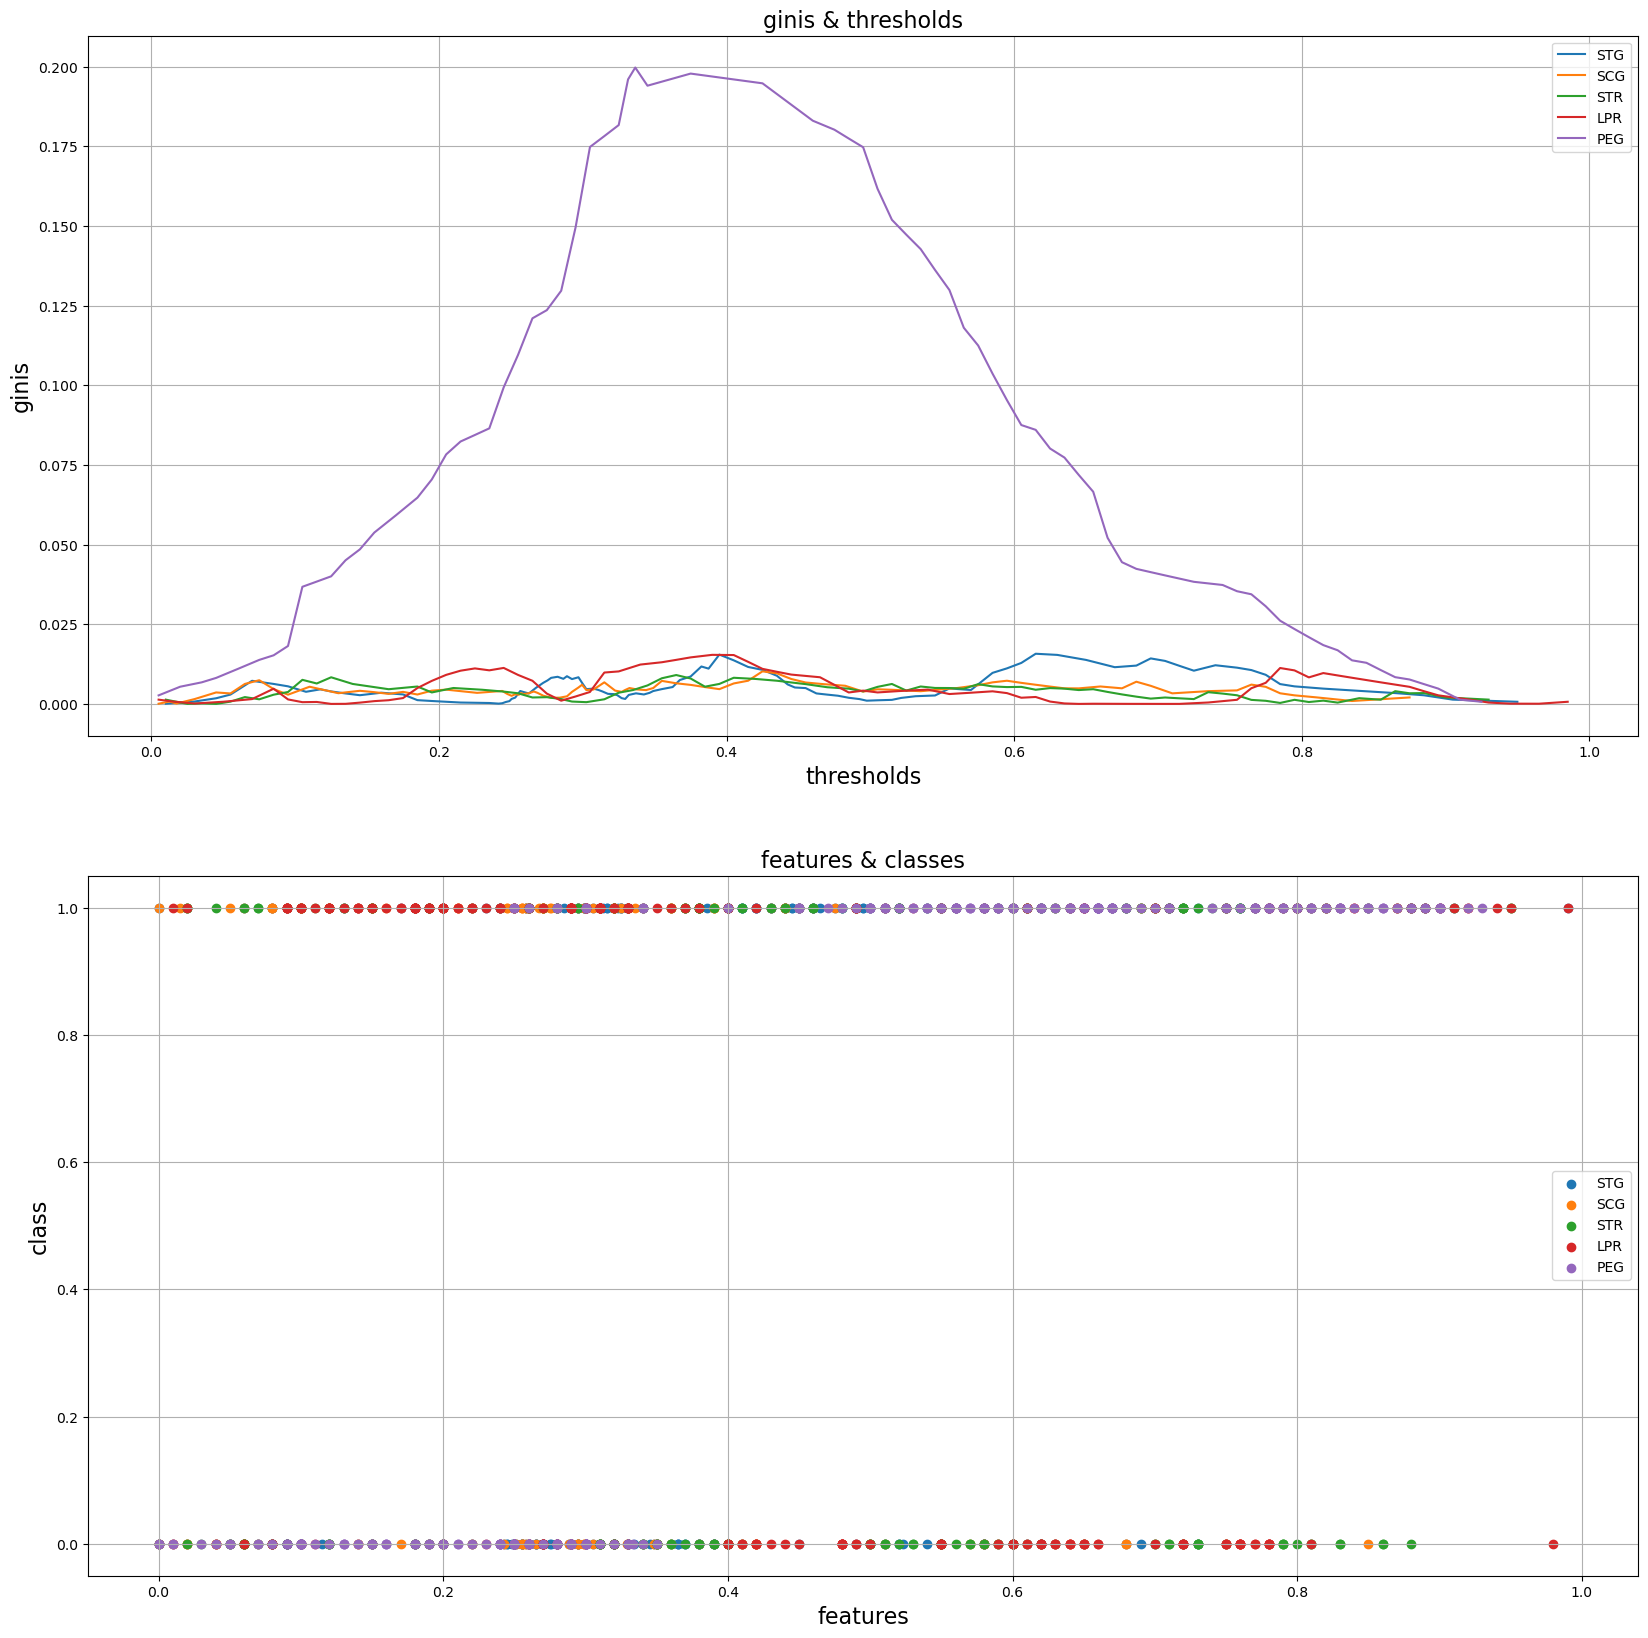

In [23]:
ginis = []
thresholds_mine = []
f, ax = plt.subplots(2,1, figsize=(20,20))
for index, column in enumerate(X.columns):
    features = X[column].to_numpy() 
    task="regression"
    feature_type="real"
    thresholds, variances, threshold_best, variance_best, Q = find_best_split(features, y,
                                                                              task=task, feature_type=feature_type)
    thresholds_mine.append(thresholds)
    ginis.append(variances)
    ax[0].plot(thresholds, variances, label=column)
    ax[1].scatter(features, y, label=column)
    
ax[0].set_xlabel('thresholds', fontsize=16)
ax[0].set_ylabel('ginis', fontsize=16)
ax[0].set_title('ginis & thresholds', fontsize=16)
ax[0].legend()
ax[0].grid()

ax[1].set_xlabel('features', fontsize=16)
ax[1].set_ylabel('class', fontsize=16)
ax[1].set_title('features & classes', fontsize=16)
ax[1].legend()
ax[1].grid()
plt.show()

#### *Исходя из кривых значений критерия Джини видно, что производить деление выборки на два поддерева стоит по признаку PEG. *  Полученные выводы исходят из визуальной оценки диаграммы рассеяния, где видно, что при трешхолде равном примерно ~0.4 можно очень точно разделить выборку значений признака PEG. Кривая для "хороших" признаков волнообразна с характерной "горной вершиной". Кривые для признаков, по которым деление практически невозможно выглядят примерно как сплошная линия с небольшими амплетудами колебаний.*

$$
Q(R_m, j, t) = \frac{|R_\ell|}{|R_m|}H(R_\ell) + \frac{|R_r|}{|R_m|}H(R_r),
$$


Протестируем свое решающее дерево на датасете [mushrooms](https://archive.ics.uci.edu/ml/datasets/Mushroom). 

In [24]:
mushrooms_data = pd.read_csv('./agaricus-lepiota.data')
mushrooms_data

p  x  s  n  t p.1  f  c n.1  k  ... s.2  w w.1 p.2 w.2  o p.3 k.1 s.3  u
0     e  x  s  y  t   a  f  c   b  k  ...   s  w   w   p   w  o   p   n   n  g
1     e  b  s  w  t   l  f  c   b  n  ...   s  w   w   p   w  o   p   n   n  m
2     p  x  y  w  t   p  f  c   n  n  ...   s  w   w   p   w  o   p   k   s  u
3     e  x  s  g  f   n  f  w   b  k  ...   s  w   w   p   w  o   e   n   a  g
4     e  x  y  y  t   a  f  c   b  n  ...   s  w   w   p   w  o   p   k   n  g
...  .. .. .. .. ..  .. .. ..  .. ..  ...  .. ..  ..  ..  .. ..  ..  ..  .. ..
8118  e  k  s  n  f   n  a  c   b  y  ...   s  o   o   p   o  o   p   b   c  l
8119  e  x  s  n  f   n  a  c   b  y  ...   s  o   o   p   n  o   p   b   v  l
8120  e  f  s  n  f   n  a  c   b  n  ...   s  o   o   p   o  o   p   b   c  l
8121  p  k  y  n  f   y  f  c   n  b  ...   k  w   w   p   w  o   e   w   v  l
8122  e  x  s  n  f   n  a  c   b  y  ...   s  o   o   p   o  o   p   o   c  l

[8123 rows x 23 columns]

In [25]:
mushrooms_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8123 entries, 0 to 8122
Data columns (total 23 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   p       8123 non-null   object
 1   x       8123 non-null   object
 2   s       8123 non-null   object
 3   n       8123 non-null   object
 4   t       8123 non-null   object
 5   p.1     8123 non-null   object
 6   f       8123 non-null   object
 7   c       8123 non-null   object
 8   n.1     8123 non-null   object
 9   k       8123 non-null   object
 10  e       8123 non-null   object
 11  e.1     8123 non-null   object
 12  s.1     8123 non-null   object
 13  s.2     8123 non-null   object
 14  w       8123 non-null   object
 15  w.1     8123 non-null   object
 16  p.2     8123 non-null   object
 17  w.2     8123 non-null   object
 18  o       8123 non-null   object
 19  p.3     8123 non-null   object
 20  k.1     8123 non-null   object
 21  s.3     8123 non-null   object
 22  u       8123 non-null   

In [26]:
import sklearn
l_encoder = sklearn.preprocessing.LabelEncoder()
l_mushrooms_data = mushrooms_data.apply(l_encoder.fit_transform)
l_mushrooms_data

p  x  s  n  t  p.1  f  c  n.1   k  ...  s.2  w  w.1  p.2  w.2  o  p.3  \
0     0  5  2  9  1    0  1  0    0   4  ...    2  7    7    0    2  1    4   
1     0  0  2  8  1    3  1  0    0   5  ...    2  7    7    0    2  1    4   
2     1  5  3  8  1    6  1  0    1   5  ...    2  7    7    0    2  1    4   
3     0  5  2  3  0    5  1  1    0   4  ...    2  7    7    0    2  1    0   
4     0  5  3  9  1    0  1  0    0   5  ...    2  7    7    0    2  1    4   
...  .. .. .. .. ..  ... .. ..  ...  ..  ...  ... ..  ...  ...  ... ..  ...   
8118  0  3  2  4  0    5  0  0    0  11  ...    2  5    5    0    1  1    4   
8119  0  5  2  4  0    5  0  0    0  11  ...    2  5    5    0    0  1    4   
8120  0  2  2  4  0    5  0  0    0   5  ...    2  5    5    0    1  1    4   
8121  1  3  3  4  0    8  1  0    1   0  ...    1  7    7    0    2  1    0   
8122  0  5  2  4  0    5  0  0    0  11  ...    2  5    5    0    1  1    4   

      k.1  s.3  u  
0       3    2  1  
1       3    2  3  
2       2    3  5  
3       3    0  1  
4       2    2  1  
...   ...  ... ..  
8118    0    1  2  
8119    0    4  2  
8120    0    1  2  
8121    7    4  2  
8122    4    1  2  

[8123 rows x 23 columns]

In [27]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(l_mushrooms_data, test_size=0.5, random_state=2002)

In [28]:
y_train = train.iloc[:, 0]
X_train = train.iloc[:, 1:]

y_test = test.iloc[:, 0]
X_test = test.iloc[:, 1:]

In [29]:
custom_tree = DecisionTree(feature_types=['categorical']*22)
classifier = custom_tree.fit(np.array(X_train), y_train.to_numpy())

In [30]:
y_pred = custom_tree.predict(np.array(X_test))
print(sklearn.metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2111
           1       1.00      1.00      1.00      1951

    accuracy                           1.00      4062
   macro avg       1.00      1.00      1.00      4062
weighted avg       1.00      1.00      1.00      4062



In [31]:
custom_tree.__dict__

{'_tree': {'type': 'nonterminal',
  'feature_split': 8,
  'category_split': 3.5,
  'left_child': {'type': 'nonterminal',
   'feature_split': 20,
   'category_split': 3.5,
   'left_child': {'type': 'nonterminal',
    'feature_split': 19,
    'category_split': 1.5,
    'left_child': {'type': 'terminal', 'class': 1},
    'right_child': {'type': 'nonterminal',
     'feature_split': 7,
     'category_split': 0.5,
     'left_child': {'type': 'terminal', 'class': 0},
     'right_child': {'type': 'terminal', 'class': 1}}},
   'right_child': {'type': 'nonterminal',
    'feature_split': 10,
    'category_split': 2.0,
    'left_child': {'type': 'nonterminal',
     'feature_split': 12,
     'category_split': 0.5,
     'left_child': {'type': 'nonterminal',
      'feature_split': 1,
      'category_split': 2.5,
      'left_child': {'type': 'terminal', 'class': 1},
      'right_child': {'type': 'terminal', 'class': 0}},
     'right_child': {'type': 'terminal', 'class': 1}},
    'right_child': {'type'

В данной части мы будем работать [с задачей предсказания диабета у пациента](https://www.kaggle.com/uciml/pima-indians-diabetes-database/data). Посмотрим на работу бэггинга над решающими деревьями и случайного леса, сравним их работу.

In [32]:
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

In [33]:
data = pd.read_csv('./diabetes.csv')
print(f"Dataset shape: {data.shape}")
data.head(10)

Dataset shape: (768, 9)


Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0            6      148             72             35        0  33.6   
1            1       85             66             29        0  26.6   
2            8      183             64              0        0  23.3   
3            1       89             66             23       94  28.1   
4            0      137             40             35      168  43.1   
5            5      116             74              0        0  25.6   
6            3       78             50             32       88  31.0   
7           10      115              0              0        0  35.3   
8            2      197             70             45      543  30.5   
9            8      125             96              0        0   0.0   

   DiabetesPedigreeFunction  Age  Outcome  
0                     0.627   50        1  
1                     0.351   31        0  
2                     0.672   32        1  
3                     0.167   21        0  
4                     2.288   33        1  
5                     0.201   30        0  
6                     0.248   26        1  
7                     0.134   29        0  
8                     0.158   53        1  
9                     0.232   54        1

Посмотрим на распределение целевой переменной

<AxesSubplot:>

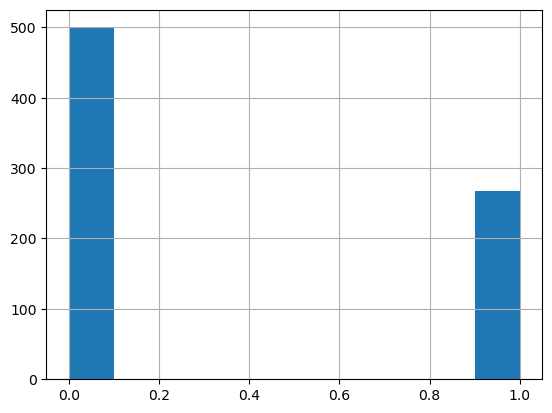

In [34]:
data['Outcome'].hist()

In [35]:
y = data['Outcome']
data.drop('Outcome', axis=1, inplace=True)

In [36]:
X_train, X_test, y_train, y_test = train_test_split(data, y, test_size=0.3, random_state=4602)
X_train_sub, X_val, y_train_sub, y_val = train_test_split(X_train, y_train, test_size=0.3, random_state=2002)

In [37]:
from sklearn.metrics import f1_score
max_depth = [1, 3, 5, 7, 9, 11, 13]
min_samples_leaf = [1, 2, 3, 4, 5]
f1_values = pd.DataFrame(index=['macro', 'micro', 'weighted'])

for index_depth, depth in enumerate(max_depth):
    for index_leaf, leaf in enumerate(min_samples_leaf):
        tree = DecisionTreeClassifier(max_depth=depth, min_samples_leaf=leaf)
        tree.fit(X_train_sub, y_train_sub)
        predictions = tree.predict(X_val)
        
        macro = f1_score(y_val, predictions, average='macro')
        micro = f1_score(y_val, predictions, average='micro')
        weighted = f1_score(y_val, predictions, average='weighted')
        f1_values[f"depth->{depth}, n_leaves->{leaf}"] = [macro, micro, weighted]

all_means = pd.DataFrame(f1_values.mean(axis=0)).T
all_means.index = ['mean']
f1_values = pd.concat([f1_values, all_means])
maximum = f1_values.iloc[3].max()
f1_values

depth->1, n_leaves->1  depth->1, n_leaves->2  depth->1, n_leaves->3  \
macro                  0.717367               0.717367               0.717367   
micro                  0.728395               0.728395               0.728395   
weighted               0.731152               0.731152               0.731152   
mean                   0.725638               0.725638               0.725638   

          depth->1, n_leaves->4  depth->1, n_leaves->5  depth->3, n_leaves->1  \
macro                  0.717367               0.717367               0.710960   
micro                  0.728395               0.728395               0.740741   
weighted               0.731152               0.731152               0.733868   
mean                   0.725638               0.725638               0.728523   

          depth->3, n_leaves->2  depth->3, n_leaves->3  depth->3, n_leaves->4  \
macro                  0.710960               0.710960               0.713941   
micro                  0.740741               0.740741               0.746914   
weighted               0.733868               0.733868               0.737921   
mean                   0.728523               0.728523               0.732925   

          depth->3, n_leaves->5  ...  depth->11, n_leaves->1  \
macro                  0.713941  ...                0.658863   
micro                  0.746914  ...                0.685185   
weighted               0.737921  ...                0.682260   
mean                   0.732925  ...                0.675436   

          depth->11, n_leaves->2  depth->11, n_leaves->3  \
macro                   0.663640                0.688722   
micro                   0.685185                0.716049   
weighted                0.684660                0.711495   
mean                    0.677828                0.705422   

          depth->11, n_leaves->4  depth->11, n_leaves->5  \
macro                   0.682975                0.672507   
micro                   0.722222                0.703704   
weighted                0.710517                0.697464   
mean                    0.705238                0.691225   

          depth->13, n_leaves->1  depth->13, n_leaves->2  \
macro                   0.653483                0.655882   
micro                   0.685185                0.679012   
weighted                0.679362                0.677911   
mean                    0.672677                0.670935   

          depth->13, n_leaves->3  depth->13, n_leaves->4  \
macro                   0.672241                0.677514   
micro                   0.697531                0.716049   
weighted                0.694721                0.705039   
mean                    0.688164                0.699534   

          depth->13, n_leaves->5  
macro                   0.677960  
micro                   0.709877  
weighted                0.702993  
mean                    0.696943  

[4 rows x 35 columns]

In [38]:
best_hyperparametres = f1_values.apply(lambda x: [(x.name, value) for value, 
                                                  best_hyperparametres in zip(f1_values.columns, x) if best_hyperparametres == maximum], axis=1).explode().tolist()
best_hyperparametres = [x for x in best_hyperparametres if pd.notnull(x)]
best_hyperparametres

[('mean', 'depth->5, n_leaves->4'), ('mean', 'depth->5, n_leaves->5')]

In [39]:
best_hyperparametres = [int(best_hyperparametres[0][1].split('depth->')[1].split(',')[0]), int(best_hyperparametres[0][1].split('n_leaves->')[1])]
best_hyperparametres

[5, 4]

### **Из массива видно, что наибольшее среднее значение ф-меры имеют деревья с такими гиперпараметрами как:**
*  глубина - 3, количество листьев - 1
*  глубина - 3, количество листьев - 2
*  глубина - 3, количество листьев - 3

In [40]:
final_tree = DecisionTreeClassifier(max_depth=best_hyperparametres[0], min_samples_leaf=best_hyperparametres[1])
final_tree.fit(X_train, y_train)
y_pred = final_tree.predict(X_test)

def get_metrics(y_test, y_pred):
    # f1_score
    macro = f1_score(y_test, y_pred, average='macro')
    micro = f1_score(y_test, y_pred, average='micro')
    weighted = f1_score(y_test, y_pred, average='weighted')

    # accuracy
    accuracy = sklearn.metrics.accuracy_score(y_test, y_pred)

    # precision
    precision = sklearn.metrics.precision_score(y_test, y_pred)

    # recall 
    recall = sklearn.metrics.recall_score(y_test, y_pred)
    true_negative, _, _, _ = sklearn.metrics.confusion_matrix(y_test, y_pred).ravel()
    false_positive_rate, true_positive_rate, threshold = sklearn.metrics.roc_curve(y_test, y_pred)
    # auc-roc
    auc_roc = roc_auc_score(y_test, y_pred)

    metrics = np.array([macro, micro, weighted, accuracy, precision, recall, auc_roc])
    metrics = pd.DataFrame(metrics.reshape(1, 7), columns=['macro f1', 'micro f1', 'weighted f1', 
                                         'accuracy', 'precision', 'recall', 'auc-roc'], index=['values'])
    plt.figure(figsize=(16,8))
    plt.title('AUC-ROC')
    plt.plot(false_positive_rate, true_positive_rate, color='b', label='tree auc-roc')
    plt.plot([0, 1], ls="--", color='r', label='bad auc-roc')
    plt.plot([0, 0], [1, 0] , c=".7")
    plt.plot([1, 1] , c=".7", label='good auc-roc')
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.legend()
    plt.fill_between(false_positive_rate, true_positive_rate, color='w', hatch="+", edgecolor="b", linewidth=0.0)
    plt.fill_between(np.arange(0,1.01, 0.01), np.arange(0,1.01, 0.01), color='w', hatch="//", edgecolor="r", linewidth=0.0, 
                     zorder=2, alpha=0.5)
    plt.grid()
    plt.show()
    
    return metrics

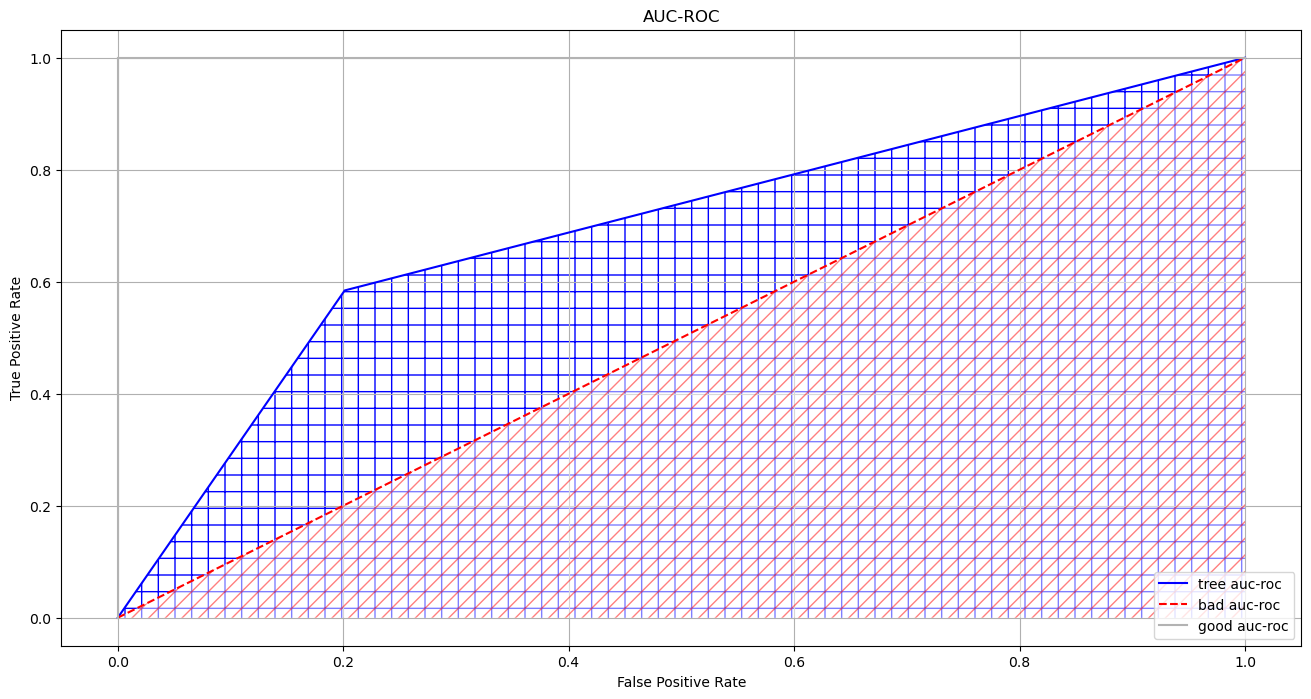

macro f1  micro f1  weighted f1  accuracy  precision    recall  \
values  0.692176  0.727273     0.726823  0.727273   0.592105  0.584416   

         auc-roc  
values  0.691558

In [41]:
metrics_d_tree = get_metrics(y_test, y_pred)
metrics_d_tree

In [42]:
bagging_classifier = BaggingClassifier(n_estimators=50)
bagging_classifier.fit(X_train, y_train)
y_pred_bagging = bagging_classifier.predict(X_test)

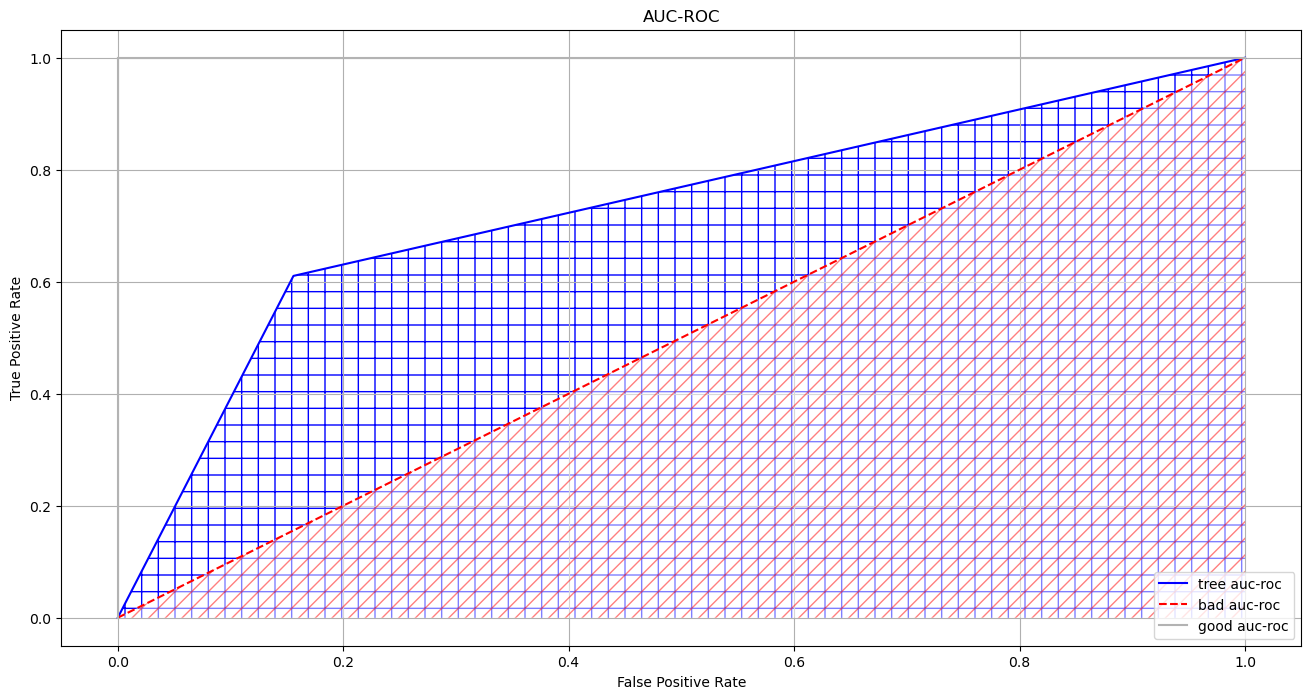

macro f1  micro f1  weighted f1  accuracy  precision   recall  \
values   0.73158  0.766234     0.763729  0.766234   0.661972  0.61039   

         auc-roc  
values  0.727273

In [43]:
metrics_bagging = get_metrics(y_test, y_pred_bagging)
metrics_bagging

In [44]:
from sklearn.model_selection import KFold

In [45]:
f1_values = pd.DataFrame(index=['macro', 'micro', 'weighted'])
for index_depth, depth in enumerate(max_depth):
    for index_leaf, leaf in enumerate(min_samples_leaf):
        macros = []
        micros = []
        weighteds = []
        kf = KFold(n_splits=3).split(X_train, y_train)
        for (train, test) in kf:
            tree = RandomForestClassifier(n_estimators=50, max_depth=depth, min_samples_leaf=leaf)
            tree.fit(X_train.iloc[train, :], y_train.iloc[train])
            predictions = tree.predict(X_train.iloc[test, :])
        
            macro = f1_score(y_train.iloc[test], predictions, average='macro')
            micro = f1_score(y_train.iloc[test], predictions, average='micro')
            weighted = f1_score(y_train.iloc[test], predictions, average='weighted')
            macros.append(macro)
            micros.append(micro)
            weighteds.append(weighted)
        
        mean_macro = np.mean(macros)
        mean_micro = np.mean(micros)
        mean_weighted = np.mean(weighteds)
        f1_values[f"depth->{depth}, n_leaves->{leaf}"] = [mean_macro, mean_micro, mean_weighted]
        
all_means = pd.DataFrame(f1_values.mean(axis=0)).T
all_means.index = ['mean']
f1_values = pd.concat([f1_values, all_means])
maximum = f1_values.iloc[3].max()
f1_values

depth->1, n_leaves->1  depth->1, n_leaves->2  depth->1, n_leaves->3  \
macro                  0.488161               0.474496               0.483720   
micro                  0.668529               0.668529               0.664804   
weighted               0.572999               0.564097               0.569393   
mean                   0.576563               0.569041               0.572639   

          depth->1, n_leaves->4  depth->1, n_leaves->5  depth->3, n_leaves->1  \
macro                  0.498183               0.527194               0.672139   
micro                  0.670391               0.679702               0.733706   
weighted               0.580136               0.600033               0.712860   
mean                   0.582903               0.602310               0.706235   

          depth->3, n_leaves->2  depth->3, n_leaves->3  depth->3, n_leaves->4  \
macro                  0.698484               0.723890               0.665872   
micro                  0.752328               0.769088               0.728119   
weighted               0.735870               0.755841               0.707946   
mean                   0.728894               0.749606               0.700646   

          depth->3, n_leaves->5  ...  depth->11, n_leaves->1  \
macro                  0.702791  ...                0.719741   
micro                  0.748603  ...                0.754190   
weighted               0.736779  ...                0.747975   
mean                   0.729391  ...                0.740636   

          depth->11, n_leaves->2  depth->11, n_leaves->3  \
macro                   0.708008                0.696212   
micro                   0.748603                0.737430   
weighted                0.740560                0.728841   
mean                    0.732391                0.720828   

          depth->11, n_leaves->4  depth->11, n_leaves->5  \
macro                   0.696060                0.712367   
micro                   0.739292                0.752328   
weighted                0.729767                0.743708   
mean                    0.721706                0.736134   

          depth->13, n_leaves->1  depth->13, n_leaves->2  \
macro                   0.709296                0.708473   
micro                   0.748603                0.744879   
weighted                0.740477                0.738189   
mean                    0.732792                0.730514   

          depth->13, n_leaves->3  depth->13, n_leaves->4  \
macro                   0.700867                0.701609   
micro                   0.739292                0.743017   
weighted                0.731853                0.734152   
mean                    0.724004                0.726259   

          depth->13, n_leaves->5  
macro                   0.707219  
micro                   0.744879  
weighted                0.738268  
mean                    0.730122  

[4 rows x 35 columns]

In [46]:
best_hyperparametres = f1_values.apply(lambda x: [(x.name, value) for value, 
                                                  best_hyperparametres in zip(f1_values.columns, x) if best_hyperparametres == maximum], axis=1).explode().tolist()
best_hyperparametres = [x for x in best_hyperparametres if pd.notnull(x)]
best_hyperparametres

[('mean', 'depth->7, n_leaves->3')]

In [47]:
best_hyperparametres = [int(best_hyperparametres[0][1].split('depth->')[1].split(',')[0]), int(best_hyperparametres[0][1].split('n_leaves->')[1])]
best_hyperparametres

[7, 3]

In [48]:
final_tree = RandomForestClassifier(n_estimators=50, 
                                    max_depth=best_hyperparametres[0], 
                                    min_samples_leaf=best_hyperparametres[1])
final_tree.fit(X_train, y_train)
y_pred = final_tree.predict(X_test)

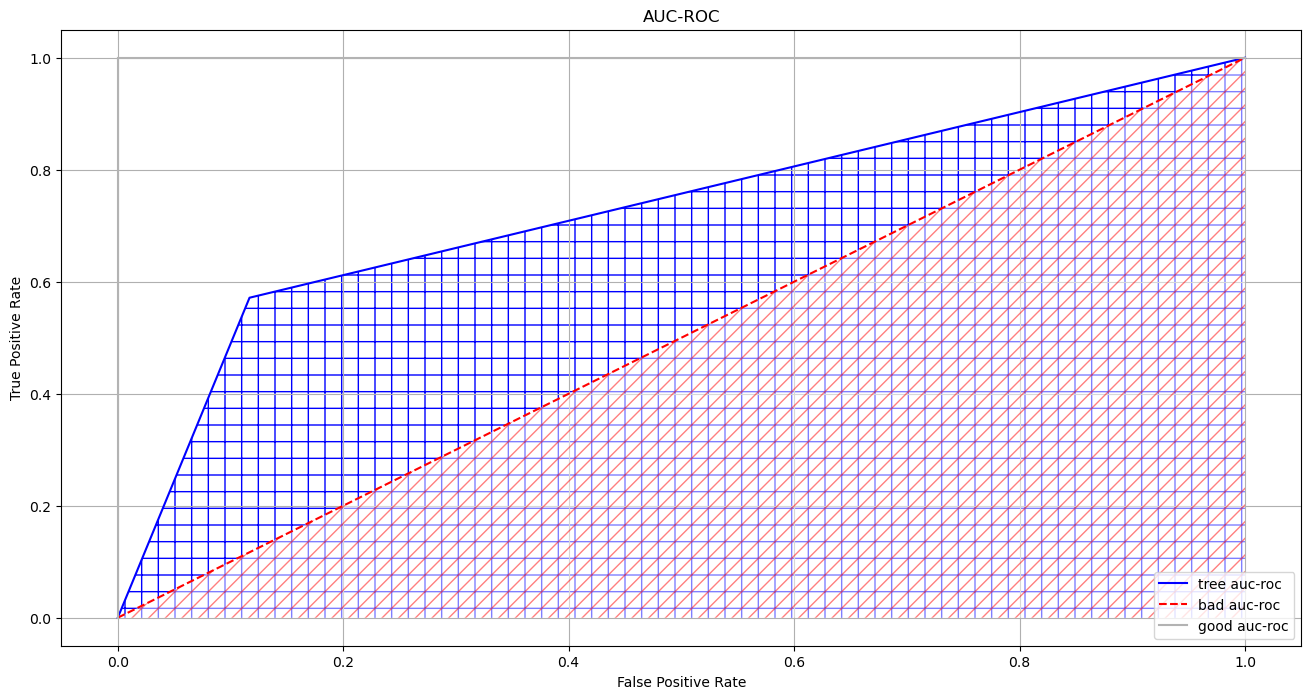

macro f1  micro f1  weighted f1  accuracy  precision    recall  \
values  0.737599  0.779221     0.772435  0.779221   0.709677  0.571429   

         auc-roc  
values  0.727273

In [49]:
metrics_ensemble = get_metrics(y_test, y_pred)
metrics_ensemble

### RandomForest с кросс валидацией показал себя лучше всего по все параметрам!
-------------------------------

Построим график зависимости AUC ROC на тестовой выборке от числа деревьев (`n_estimators`) для случайного леса, обучаемого на **полной обучающей** выборке. Какие выводы можно сделать?

In [50]:
def auc_roc_n_estimators_dependency(X_train:np.array, 
                                    y_train:np.array,
                                    X_test:np.array, 
                                    y_test:np.array, n_estimators:np.array, best_hyperparametres: list):
    aucs = []
    forests = []
    for estimator in n_estimators:
        forest = RandomForestClassifier(n_estimators=estimator, 
                                        max_depth=best_hyperparametres[0], min_samples_leaf=best_hyperparametres[1])
        forest.fit(X_train, y_train)
        y_pred = forest.predict(X_test)
        auc_roc = roc_auc_score(y_test, y_pred)
        forests.append(forest)
        aucs.append(auc_roc)
    f, ax = plt.subplots(1,1, figsize=(16,8))
    ax.plot(n_estimators, aucs, label='auc & number of estimators', ls='--', c='blue')
    ax.set_xlabel('number of estimators', fontsize=16)
    ax.set_ylabel('auc-roc value', fontsize=16)
    ax.set_title('auc & number of estimators', fontsize=16)
    ax.scatter(n_estimators[np.argmax(aucs)],max(aucs), c='r', s=100)
    plt.annotate('max auc-roc', xy=(n_estimators[np.argmax(aucs)],max(aucs)), 
                 xytext=(n_estimators[np.argmax(aucs)]-5, max(aucs)-0.02),
                 arrowprops=dict(facecolor='black', shrink=0.05))
    ax.grid()
    plt.show()
    print('best number of estimators -> ', n_estimators[np.argmax(aucs)], "\n",
          'best auc-roc -> ',max(aucs), "\n",
          'index of best forest -> ',np.argmax(aucs), sep='')
    
    return forests[np.argmax(aucs)]

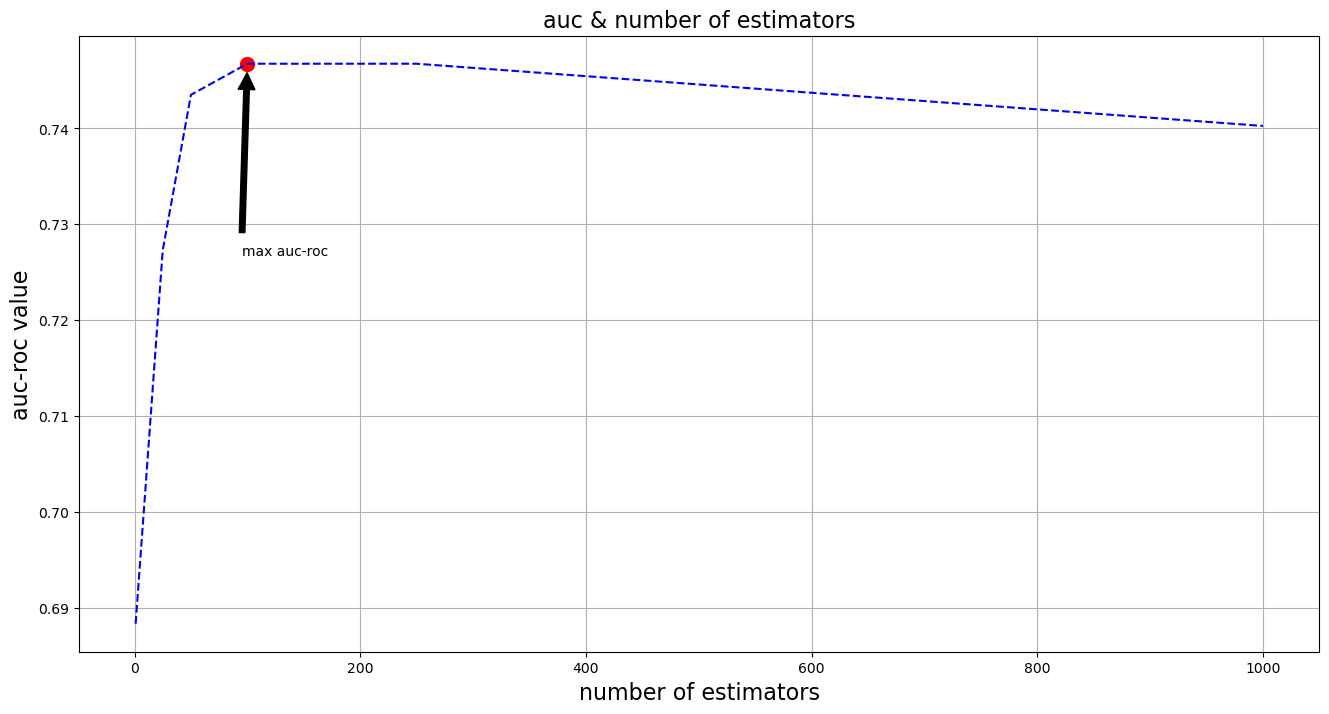

best number of estimators -> 100
best auc-roc -> 0.7467532467532467
index of best forest -> 3


In [51]:
number_of_estimators = [1, 25, 50, 100, 250, 1000]
best_forest = auc_roc_n_estimators_dependency(X_train, y_train, X_test, y_test, number_of_estimators, best_hyperparametres)

#### Не всегда количество эстиматоров соответсвует хорошему качеству модели, нужно подбирать оптимальное количество деревьев для обучения случайного леса.
----------------

**Задание 3.6 (0.5 балла)** Для лучшей модели случайного леса из **Задания 3.4** посчитаем важность признаков и построим bar plot. Какой признак оказался самым важным для определения диабета?

In [52]:
feature_importancies = pd.DataFrame(best_forest.feature_importances_)
feature_importancies.index = X_train.columns
feature_importancies.columns = ['importancy']
feature_importancies

importancy
Pregnancies                 0.099679
Glucose                     0.277478
BloodPressure               0.062155
SkinThickness               0.062900
Insulin                     0.087150
BMI                         0.182119
DiabetesPedigreeFunction    0.094465
Age                         0.134055

In [53]:
pd.options.plotting.backend = "plotly"
feature_importancies.plot.barh()

### Как видно из графика самым значимым признаком является glucose!
